In [10]:
import imageio
import skimage
import os
import sys
import cv2
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from scipy.spatial import Delaunay

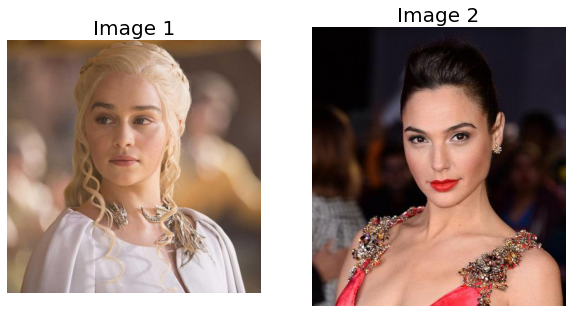

In [20]:
root_folder = os.path.dirname(os.getcwd())                  # get repo root folder
sys.path.insert(0, root_folder)                             # Add root folder to path. Needed so the DIP library can be imported.        
from DIP_Library import warp_image, featureDetectionDLIB    # Import the DIP lib

face_folder =  root_folder + "\\resources\\imgs\\faces\\"   # appende image folder
img_name_1 = "daenerys.jpg"                                 # random face as input
img_name_2 = "gal_gadot.jpg"

img1 = imageio.imread(face_folder+img_name_1)               # load the image
img1 = skimage.util.img_as_float(img1)                      # Convert image data type

img2 = imageio.imread(face_folder+img_name_2)               # load the image
img2 = skimage.util.img_as_float(img2) 

plt.rcParams['figure.figsize'] = [10, 10]
plt.subplot(121);plt.title('Image 1',fontsize=20);plt.axis('off');plt.imshow(img1)
plt.subplot(122);plt.title('Image 2',fontsize=20);plt.axis('off');plt.imshow(img2)
model = root_folder + "\\resources\\Models\\shape_predictor_68_face_landmarks.dat"
#model = root_folder + "\\resources\\Models\\shape_predictor_5_face_landmarks.dat"

In [12]:
def face_morph(image1, image2 ,model, alphas=0.5, landmarks=False,):
    """Morph 2 faces togheter with a given model and alpha value. Multiple alpha values van be provides. With the landmark bool it is poissible to plot the 2 
       images with the landmark triangles. If the output frames will be used to create a video file make sure the input images are the same size!
       For single frame output the output frame is sliced to remove the black areas.

    Args:
        image1 (ndarray): _description_
        image2 (ndarray): _description_
        model (string) : path to the model used to detect landmarks. Made this a parameter for flexibility reasons 
        alphas (float, optional): Single value or array of values between [0, 1] 
        landmarks (bool, optional): Print the triangles on the original pictures

    Returns:
        list: a list that contains a morphed image for eacht given alpha. Default 1 frame for alpha 0.5
    """
    pts1 = featureDetectionDLIB(image1,model, True, True)           # Generate features
    pts2 = featureDetectionDLIB(image2,model, True, True)
    triangles1 = Delaunay(pts1)                                     # Get list of triangles (image1)
    triangles2 = Delaunay(pts2)                                     # Get list of triangles (image2)

    if landmarks:       
        fig, (ax) = plt.subplots(nrows=1, ncols=2)
        ax[0].axis('off')
        ax[0].imshow(image1)
        ax[0].triplot(pts1[:,0], pts1[:,1], triangles1.simplices)
        ax[1].axis('off')
        ax[1].imshow(image2)
        ax[1].triplot(pts2[:,0], pts2[:,1], triangles2.simplices)

    frames = []
    for alpha in alphas:
        ptsm = (1-alpha)*pts1 + alpha*pts2                                  # Calculate intermediate points
                                
        warped1 = warp_image(image1, pts1, triangles1,ptsm, image2.shape)   # Warp image                                 
        warped2 = warp_image(image2, pts2, triangles2,ptsm, image1.shape)   # Warp image

        morphed = img_as_ubyte((1-alpha)*warped1 + alpha*warped2)           # Add the 2 warped images together to create a morph

        newWidth = int((1-alpha)*image1.shape[0] + alpha*image2.shape[0])   # Calculate the new width and height of the warped images
        newHeight = int((1-alpha)*image1.shape[1] + alpha*image2.shape[1])

        frames.append(morphed[0:newWidth, 0:newHeight])                     # Slicing is only usefull for single frame output

    return frames

In [13]:
def save_frames_to_video(path,frames):
    w,h = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(path,fourcc,24,(w,h),isColor=True)
    for frame in frames:
        writer.write(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))
    writer.release()

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.1020408163265306
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.18367346938775508
0.2040816326530612
0.22448979591836732
0.24489795918367346
0.26530612244897955
0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464
0.4693877551020408
0.4897959183673469
0.5102040816326531
0.5306122448979591
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591836
0.6326530612244897
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857142
0.7346938775510203
0.7551020408163265
0.7755102040816326
0.7959183673469387
0.8163265306122448
0.836734693877551
0.8571428571428571
0.8775510204081632
0.8979591836734693
0.9183673469387754
0.9387755102040816
0.9591836734693877
0.9795918367346939
1.0
50


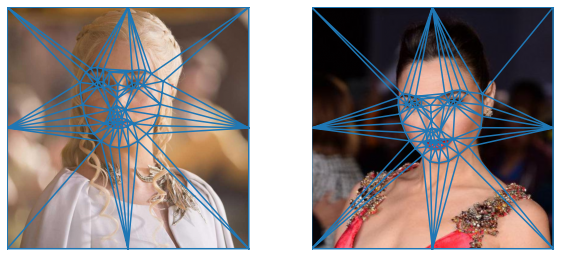

In [14]:
img2 = resize(img2, img1.shape,anti_aliasing=True)
frames = face_morph(img1, img2 ,model,alphas=np.linspace(0,1,50), landmarks=True)
print(len(frames))

In [15]:
save_frames_to_video(root_folder + "\\resources\\outputs\\morph_video.mp4", frames)